# Kalman Filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as la
from scipy.stats import multivariate_normal as mvn

plt.style.use("seaborn-v0_8")

In [2]:
dt = 1.
R_var = 1
Q_var = 0.1

x = np.array([10.0, 15]).reshape(2, 1)
P = np.diag([1, 0.1])
F = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0]])
R = np.array([[R_var]])
Q = np.array([[Q_var, 0], [0, Q_var]])

In [3]:
num_iter = 20

def generate_1d_motion(x: np.ndarray, F: np.ndarray, count) -> (np.ndarray, np.ndarray):
    xs = [x]
    for i in range(count):
        x = F @ x
        xs.append(x)
    
    return np.array(xs)

def generate_1d_measurement(x: np.ndarray, H: np.ndarray, R: np.ndarray) -> (np.ndarray, np.ndarray):
    zs = []
    for i in range(x.shape[0]):
        z = H @ x[i,:]
        r, c = z.shape
        z += mvn.rvs(mean=np.zeros(r), cov=R, size=1)
        zs.append(z.reshape(r,))
    
    return np.array(zs)

xs = generate_1d_motion(x, F, num_iter)
zs = generate_1d_measurement(xs, H, R)


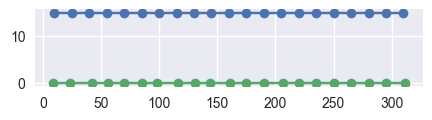

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.plot(xs[:,0], xs[:,1], 'o-')
ax.plot(zs, np.zeros_like(zs), 'o-')
plt.show()

## Prediction only

In [5]:
# Prediction only
N = 100

x_hat =  np.array([10.0, 15]).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=0.1*np.eye(2), size=1).reshape(2, 1)

x_pred = np.zeros((num_iter + 1, N, 2))
x_pred[0,:,:] = mvn.rvs(mean=x_hat.reshape(2,), cov=P, size=N)

for i in range(num_iter):
    # prediction
    x_hat = F @ x_hat
    P = F @ P @ F.T + Q
    
    x_pred[i + 1,:,:] = mvn.rvs(mean=x_hat.reshape(2,), cov=P, size=N)

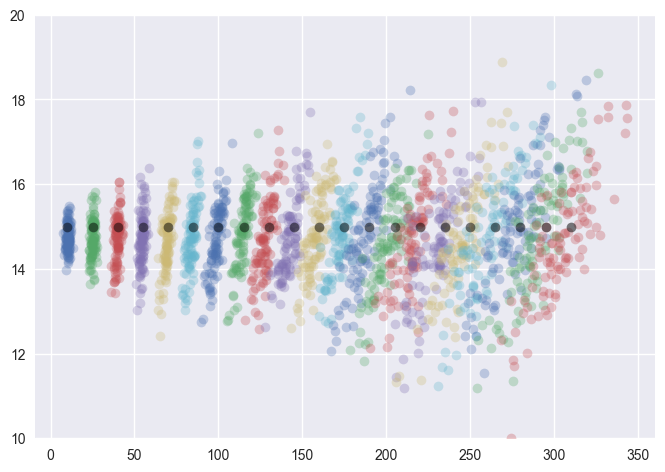

In [6]:
fig, ax = plt.subplots()

for z in range(num_iter + 1):
    ax.plot(x_pred[z,:,0], x_pred[z,:,1], 'o', alpha=0.3)

ax.plot(xs[:,0], xs[:,1], 'o', color='k', alpha=0.5)
ax.set_ylim(10, 20)

plt.show()

## Prediction and measurement update

In [7]:
def kalman_gain(P: np.ndarray, H: np.ndarray, R: np.ndarray) -> np.ndarray:
    S = H @ P @ H.T + R
    K = P @ H.T @ la.inv(S)
    return K


In [8]:
# Prediction and measurement update
N = 100

x_hat =  np.array([10.0, 15]).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=0.1*np.eye(2), size=1).reshape(2, 1)

x_meas = np.zeros((num_iter + 1, N, 2))

z = zs[0]
y = z - H @ x_hat
K = kalman_gain(P, H, R)
x_hat = x_hat + K @ (z - H @ x_hat)
P = P - K @ H @ P

x_meas[0,:,:] = mvn.rvs(mean=x_hat.reshape(2,), cov=P, size=N)

for i in range(num_iter):
    # prediction
    x_hat = F @ x_hat
    P = F @ P @ F.T + Q

    # update
    z = zs[i + 1]
    K = kalman_gain(P, H, R)
    
    x_hat = x_hat + K @ (z - H @ x_hat)
    P = P - K @ H @ P

    x_meas[i + 1,:,:] = mvn.rvs(mean=x_hat.reshape(2,), cov=P, size=N) 

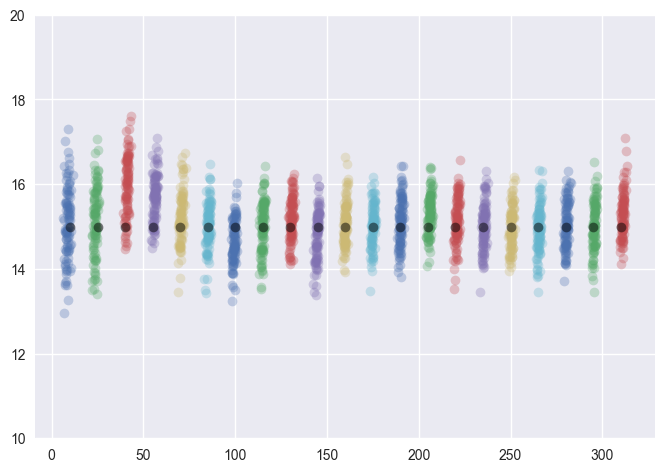

In [9]:
fig, ax = plt.subplots()

for z in range(num_iter + 1):
    ax.plot(x_meas[z,:,0], x_meas[z,:,1], 'o', alpha=0.3)

ax.plot(xs[:,0], xs[:,1], 'o', color='k', alpha=0.5)
ax.set_ylim(10, 20)

plt.show()